# Testing the `MultivariateCoupledNormal` class and entropy functions with $0 < \kappa < 1$

Use `!pip install -i https://test.pypi.org/simple/ nsc-test` to install the latest version of `nsc-test`.

# Setting up

In [1]:
import nsc_test
import numpy as np
from scipy.stats import multivariate_t, entropy
from nsc.distributions import MultivariateCoupledNormal
from nsc.math.entropy import importance_sampling_integrator
from nsc.math.entropy_norm import coupled_normal_entropy, biased_coupled_probability_norm, coupled_probability_norm, coupled_cross_entropy_norm, coupled_entropy_norm, coupled_kl_divergence_norm
import matplotlib.pyplot as plt

Importing NSC lib v0.0.0.13.
Importing NSC lib v0.0.4.12.


In [2]:
# Set the locs.
loc = np.array([[0, 0,],
                [100, -100],
                [-10, 5]])
# Set the scales.
scale = np.array([[1, 1],
                  [10, 10],
                  [1, 1]])

# Find the number of batches.
n_batches = loc.shape[0]

# Set the kappa.
kappa = 0.15

# Initialize a MultivariateCoupledNormal object.
mvn = MultivariateCoupledNormal(loc=loc, scale=scale, kappa=kappa)

# Testing `sample_n`

In [3]:
# Set the number of samples per batched distribution.
n = 10000
# Sample n observations from each batched distribution.
samples = mvn.sample_n(n)

print(f"Expected dimensions of samples: {loc.shape[0], n, loc.shape[1]}")
print(f"Actual dimensions of samples: {samples.shape}")

Expected dimensions of samples: (3, 10000, 2)
Actual dimensions of samples: (3, 10000, 2)


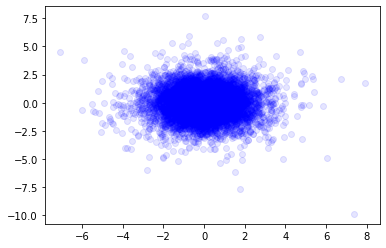

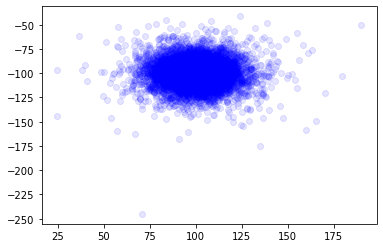

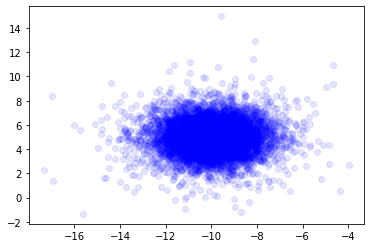

In [4]:
for i in range(samples.shape[0]):
    x, y = samples[i, :,0], samples[i, :,1]
    plt.scatter(x, y,
                color="blue", alpha=0.1)
    plt.show()

In [5]:
for i in range(n_batches):
    print(f"Mean of distribution 1: {tuple(loc[i])}")
    print(f"Mean of samples from distribution 1: {tuple(samples[i].mean(axis=0))}")
    print(f"Std. Dev. of distribution 1: {tuple(np.sqrt(((1/kappa)/(1/kappa - 2))*scale[i]**2))}")
    print(f"Std. Dev. of samples from distribution 1: {tuple(samples[i].std(axis=0))}")
    print("\n")

Mean of distribution 1: (0, 0)
Mean of samples from distribution 1: (0.00115050378261321, -0.001840539155228624)
Std. Dev. of distribution 1: (1.1952286093343936, 1.1952286093343936)
Std. Dev. of samples from distribution 1: (1.2103353168906628, 1.1890540159922351)


Mean of distribution 1: (100, -100)
Mean of samples from distribution 1: (100.02511872647524, -100.00141808267037)
Std. Dev. of distribution 1: (11.952286093343936, 11.952286093343936)
Std. Dev. of samples from distribution 1: (12.0025683574169, 11.958688311981208)


Mean of distribution 1: (-10, 5)
Mean of samples from distribution 1: (-10.004869827838723, 4.993784413937473)
Std. Dev. of distribution 1: (1.1952286093343936, 1.1952286093343936)
Std. Dev. of samples from distribution 1: (1.1846126232596776, 1.1918454786844928)




# Testing `prob` with batches (multiple distributions)

In [6]:
mvn_probs = mvn.prob(samples)

# Loop through the 
for i in range(n_batches):
    # Get the i-th distributions sample densities and reshape them to be 1-D.
    dist_1_probs = mvn_probs[i].reshape(-1,)
    # Initialize a scipy multivariate_t object.
    mvn_scipy_1 = multivariate_t(loc[i], scale[i]**2, df=1./kappa)
    # Get the probability densities from scipy object.
    scipy_probs_1 = mvn_scipy_1.pdf(samples[i])
    
    print(f"The densities from the Coupled MVN and SciPy MVN are close: {np.allclose(dist_1_probs, scipy_probs_1)}")
    print("\n")

The densities from the Coupled MVN and SciPy MVN are close: True


The densities from the Coupled MVN and SciPy MVN are close: True


The densities from the Coupled MVN and SciPy MVN are close: True




# `importance_sampling_integrator`

In [7]:
importance_sampling_integrator(mvn.prob, mvn.prob, mvn.sample_n, n=10000, seed=1)

C:\Users\jkcle\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[[1.]],

       [[1.]],

       [[1.]]])

# `coupled_normal_entropy`

In [8]:
#coupled_normal_entropy(mvn._sigma, kappa=0.0)

C:\Users\jkcle\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
#coupled_normal_entropy(mvn._sigma, kappa=0.003)

In [10]:
#mvn._sigma

In [11]:
#0.5 * np.log((2*np.pi*np.exp(1)) ** mvn.loc[0].shape[0] * np.linalg.det(mvn._sigma[0]))

# `biased_coupled_probability_norm`

In [12]:
new_mvn = biased_coupled_probability_norm(mvn, kappa=0.25, alpha=2)

print(new_mvn.loc)
print(new_mvn._sigma)
print(new_mvn.kappa)

[[   0    0]
 [ 100 -100]
 [ -10    5]]
[[[ 0.69767442  0.        ]
  [ 0.          0.69767442]]

 [[69.76744186  0.        ]
  [ 0.         69.76744186]]

 [[ 0.69767442  0.        ]
  [ 0.          0.69767442]]]
0.10465116279069767


In [13]:
new_mvn_samples = new_mvn.sample_n(n)

# `coupled_probability_norm`

In [14]:
new_mvn_pdf = coupled_probability_norm(mvn, kappa=0.25, alpha=2.0)

np.all(new_mvn_pdf(new_mvn_samples) == new_mvn.prob(new_mvn_samples))

True

# `coupled_cross_entropy_norm`

In [15]:
coupled_cross_entropy_norm(
    mvn,
    new_mvn,
    kappa=0.0, 
    alpha=2.0, 
    root=False,
    n=10000,
    seed=1
)

C:\Users\jkcle\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[[3.20536642]],

       [[7.80194668]],

       [[3.18546281]]])

# `coupled_entropy_norm`

In [16]:
coupled_entropy_norm(
    mvn,
    kappa=0.0, 
    alpha=2.0, 
    root=False,
    n=10000,
    seed=1
)

C:\Users\jkcle\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[[3.13349613]],

       [[7.73222387]],

       [[3.11856843]]])

# `coupled_kl_divergence_norm`

In [17]:
coupled_kl_divergence_norm(
    mvn, 
    new_mvn, 
    kappa=0.0, 
    alpha=2.0, 
    root=False,
    n=10000,
    seed=1
)

C:\Users\jkcle\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[[0.07187029]],

       [[0.06972281]],

       [[0.06689439]]])

In [18]:
coupled_kl_divergence_norm(
    mvn, 
    mvn, 
    kappa=0.0, 
    alpha=2.0, 
    root=False,
    n=10000,
    seed=1
)

C:\Users\jkcle\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[[0.]],

       [[0.]],

       [[0.]]])

In [19]:
coupled_kl_divergence_norm(
    new_mvn, 
    new_mvn, 
    kappa=0.0, 
    alpha=2.0, 
    root=False,
    n=10000,
    seed=1
)

C:\Users\jkcle\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[[0.]],

       [[0.]],

       [[0.]]])